# 1. Importing libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math

from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
import xgboost as xgb

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

# 2. Reading dataset

In [2]:
df = pd.read_csv("/kaggle/input/titanic/train.csv")

In [3]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 3. Investigating dataset

## Missing values


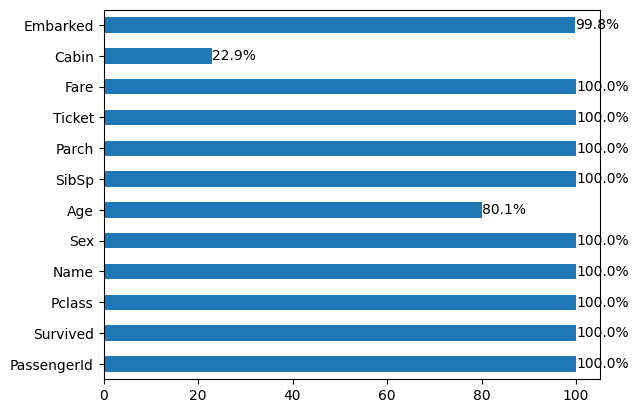

In [6]:
ax = (100*((~df.isna()).sum())/df.shape[0]).plot.barh()

for cont in ax.containers:
    ax.bar_label(cont, fmt="%.1f%%")

#df_nulls

### Investigating Embarked missing values

In [7]:
df["Embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

**Notes:**
- Only 0.2% are nan.

### Investigating Cabin missing values

In [8]:
df["Cabin"].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

Text(0.5, 0, 'NaN Percentage')

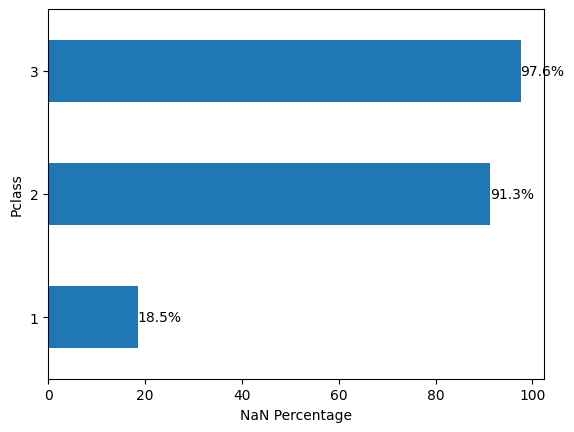

In [9]:
ax = df.groupby("Pclass")["Cabin"].apply(lambda x: x.isna().mean()*100).plot.barh()

for cont in ax.containers:
    ax.bar_label(cont, fmt= "%.1f%%")
    
plt.xlabel("NaN Percentage")


**Notes**:
- Most information about cabins is from passengers from first class.


### Investigating Age missing values

Text(0.5, 0, 'NaN Percentage')

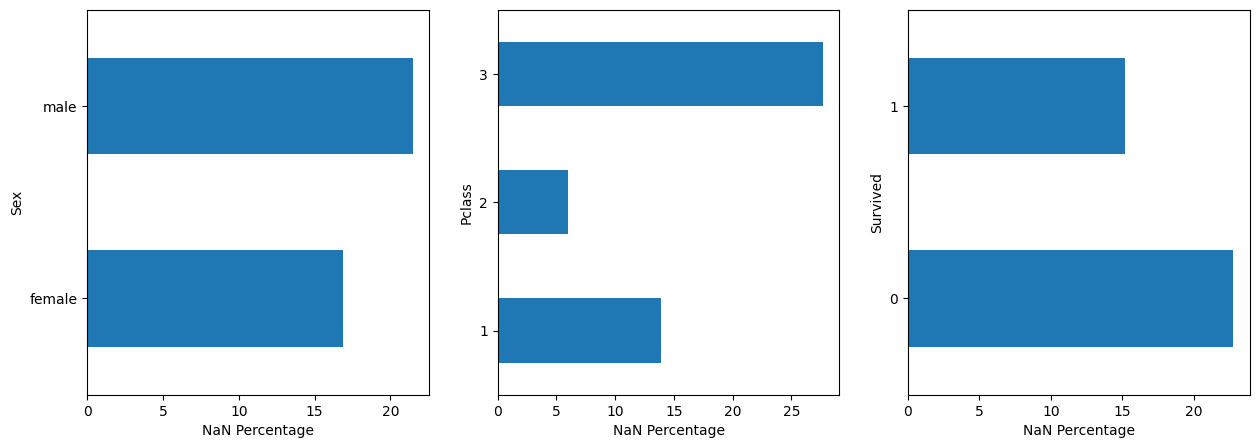

In [10]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
df.groupby("Sex")["Age"].apply(lambda x: x.isna().mean() * 100).plot.barh(ax=axes[0])
axes[0].set_xlabel("NaN Percentage")
df.groupby("Pclass")["Age"].apply(lambda x: x.isna().mean() * 100).plot.barh(ax=axes[1])
axes[1].set_xlabel("NaN Percentage")
df.groupby("Survived")["Age"].apply(lambda x: x.isna().mean() * 100).plot.barh(ax=axes[2])
axes[2].set_xlabel("NaN Percentage")

**Notes:**
- Missing values are similar for male and female
- Most NaNs are from passengers from 3rd class

## Engineering data

- Feature based on age. 
- Two others features can be created considering cabin letter and number.
- A feature can be created considering passengers titles.
- Number of relatives in the ship can be a feature.

Age clustering:
- Children: [0,12]
- Teens: [13,21]
- Adults 1: [22, 30]
- Adults 2: [31, 40]
- Adults 3: [41, 60]
- Idosos: [60, +inf]

In [11]:
def age_classification(row):
    val = row["Age"]
    
    if val<=12:
        row["AgeClass"] = 1 # child
    elif val<= 21:
        row["AgeClass"] = 2 # teen
    elif val<= 30:
        row["AgeClass"] = 3 # adult1
    elif val <= 40:
        row["AgeClass"] = 4 # adult2
    elif val <= 60:
        row["AgeClass"] = 5 # adult3
    elif val >60:
        row["AgeClass"] = 6 # old
    else:
        if "Master" in row["Name"]:
            row["AgeClass"] = 1 # child
        else:
            row["AgeClass"] = 7 #unknown
    
    return row

In [12]:
df = df.apply(age_classification, axis=1)
print(df["AgeClass"].value_counts())

AgeClass
3    205
7    173
4    155
2    135
5    128
1     73
6     22
Name: count, dtype: int64


<Axes: xlabel='AgeClass', ylabel='count'>

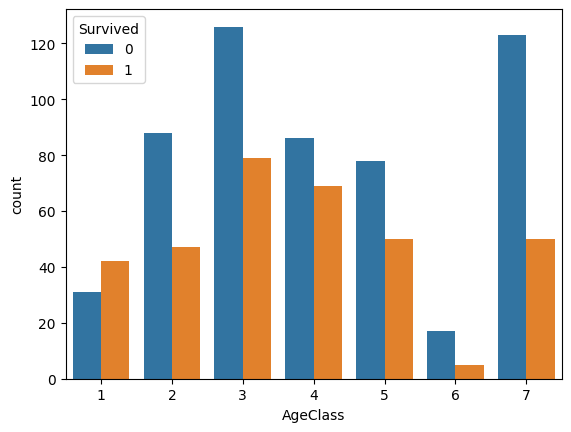

In [13]:
sns.countplot(data=df, x="AgeClass", hue="Survived")

In [14]:
def title_class(row):
    
    if "Master." in row["Name"]:
        row["Title"] = 1 # Master
    elif "Mr." in row["Name"]:
        row["Title"] = 2 # Mr
    elif "Miss." in row["Name"]:
        row["Title"] = 3 # Miss
    elif "Mrs" in row["Name"]:
        row["Title"] = 4 # Mrs
    else:
        print()
        row["Title"] = 5 # Any other ?
    
    return row

In [15]:
df = df.apply(title_class, axis=1)
print(df["Title"].value_counts())


























Title
2    517
3    182
4    127
1     40
5     25
Name: count, dtype: int64


<Axes: xlabel='Title', ylabel='count'>

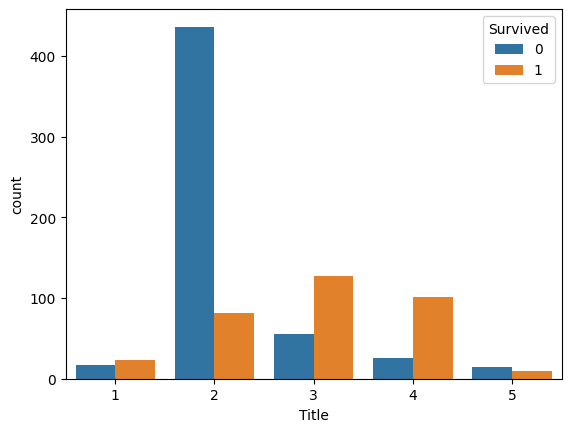

In [16]:
sns.countplot(data=df, x="Title", hue="Survived")

In [17]:
def cabin_class(row):
    try:    
        letter = re.findall(r'[A-Z]',row["Cabin"])
        letter = list(set(letter))
                      
        row["CabinLetter"] =  letter[0]
    except:
        row["CabinLetter"] =  "Unknown"
        row["CabinNumber"] =  0
        return row
    
    number = re.findall(r'[A-Z](\d+)', row["Cabin"])
    number = list(set(number))
    
    if len(number)>0:
        number = int(number[0])
        
        if number< 25:
            row["CabinNumber"] = 1
        elif number < 50:
            row["CabinNumber"] = 2
        elif number < 75:
            row["CabinNumber"] = 3
        elif number < 100:
            row["CabinNumber"] = 4
        elif number < 125:
            row["CabinNumber"] = 5
        else:
            row["CabinNumber"] = 6    
    else:
        row["CabinNumber"] = 0
    
    return row

In [18]:
df = df.apply(cabin_class, axis=1)

<Axes: xlabel='CabinNumber', ylabel='count'>

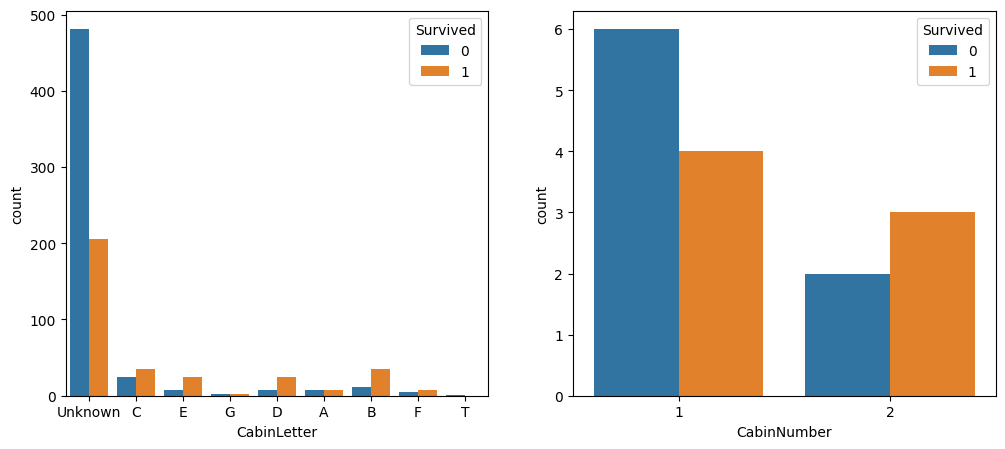

In [19]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,5))

sns.countplot(data=df, x="CabinLetter", hue="Survived", ax=axes[0])
sns.countplot(data=df[df["CabinLetter"]=="A"], x="CabinNumber", hue="Survived", ax=axes[1])

In [20]:
def relatives_class(row):
    row["Relatives"]=row["SibSp"]+row["Parch"]
    return row

In [21]:
df = df.apply(relatives_class,axis=1)

# 4. Exploratory Analysis

Dataset:

In [22]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeClass,Title,CabinLetter,CabinNumber,Relatives
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,3,2,Unknown,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4,4,C,4,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3,3,Unknown,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,4,4,C,5,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,4,2,Unknown,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,3,5,Unknown,0,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,2,3,B,2,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,7,3,Unknown,0,3
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,3,2,C,6,0


## Sex x Survivors

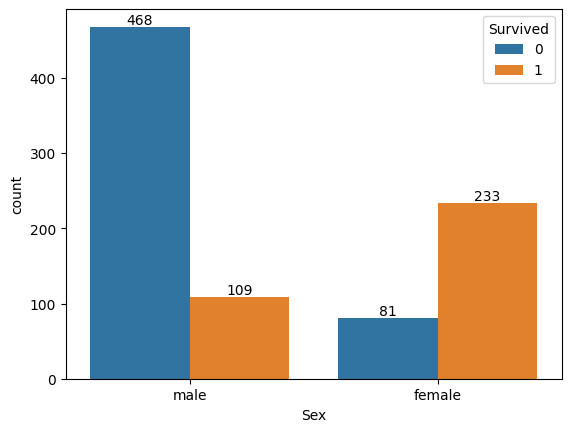

In [23]:
ax = sns.countplot(data=df, x="Sex", hue="Survived")

for cont in ax.containers:
    ax.bar_label(cont)

**Notes:**
- Majority of survivors are women, even though there were more men on the ship.

## Pclass x Survivors

<Axes: xlabel='Pclass', ylabel='count'>

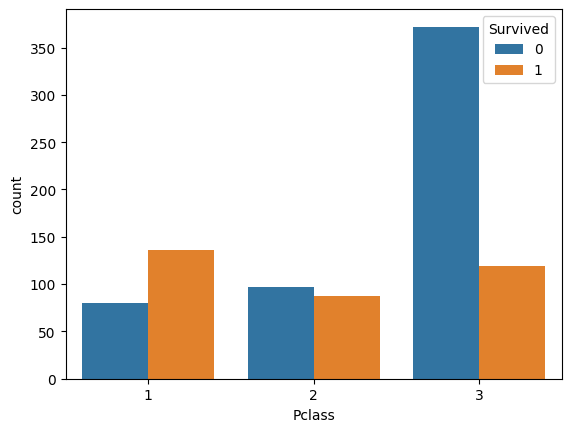

In [24]:
sns.countplot(data=df, x="Pclass", hue="Survived")

**Notes:**
- Most of the survivors are from first class.
- The ratio of survivors from first class is much higher than that of passengers from second and third class.
- The survival ratio of third-class passengers is very low.

## Embarked x Survivors

<Axes: xlabel='Embarked', ylabel='count'>

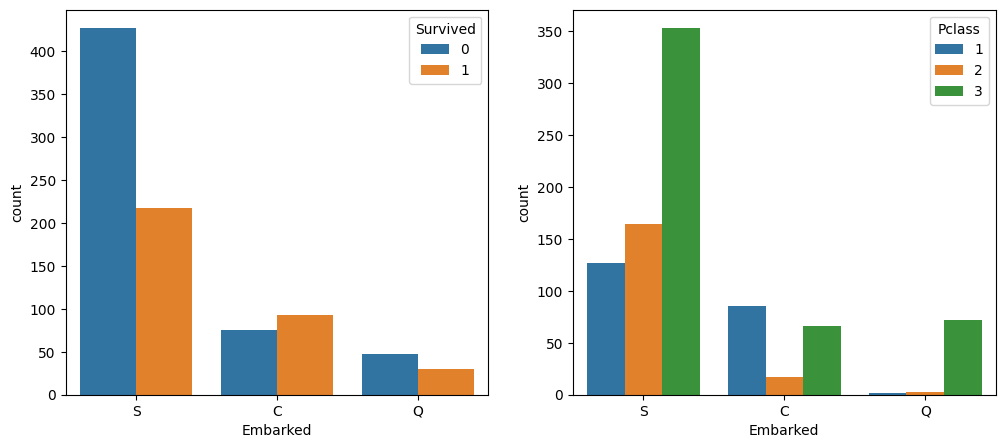

In [25]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,5))
sns.countplot(data=df, x="Embarked", hue="Survived", ax=axes[0])
sns.countplot(data=df, x="Embarked", hue="Pclass", ax=axes[1])

**Notes:**
- Most of the passengers are from Southampton. Most of them died.
- As we can see in the second graph, most of them were from third class (which can explain the high death rate).
- Even though most passengers from Queenstown were in third class, their survival rate was considerably balanced.

## Age x Survivors

<Axes: xlabel='Age', ylabel='Count'>

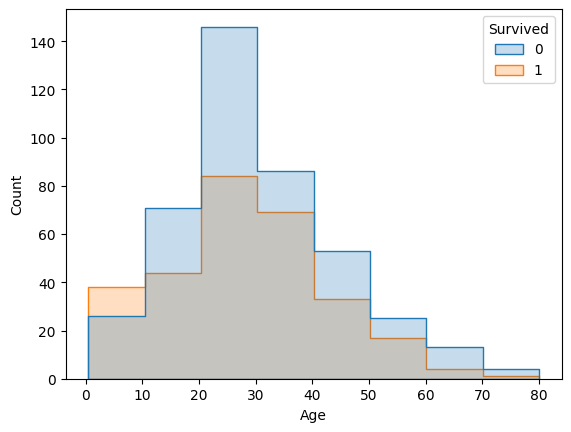

In [26]:
sns.histplot(x=df["Age"], hue=df["Survived"], element="step",bins=8)

**Notes**:
- The kids (age <= 10) had the highest survival rate.
- The kids were the only group where more survived than died.

## Title x Survivors

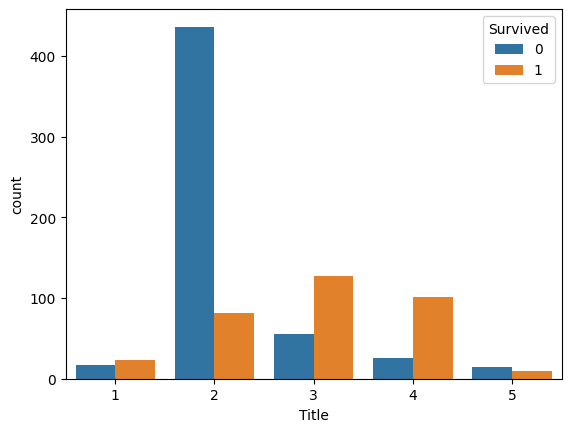

In [27]:
ax = sns.countplot(data=df, x="Title", hue="Survived")

**Notes:**
- Women and kids are more likely to survive.
- Most of the men died.

## Relatives x Survivors

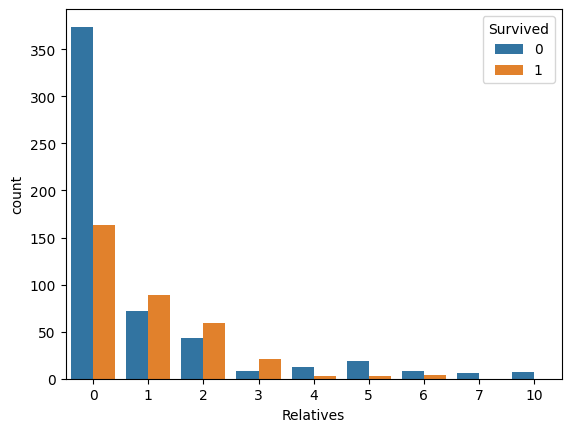

In [28]:
ax= sns.countplot(data=df, x="Relatives", hue=df["Survived"])

**Notes**:
- Passengers who were with 1, 2, or 3 relatives on the ship were more likely to survive.

## Cabin x Survivors

Text(627.9949494949494, 0.5, 'Cabin numbers')

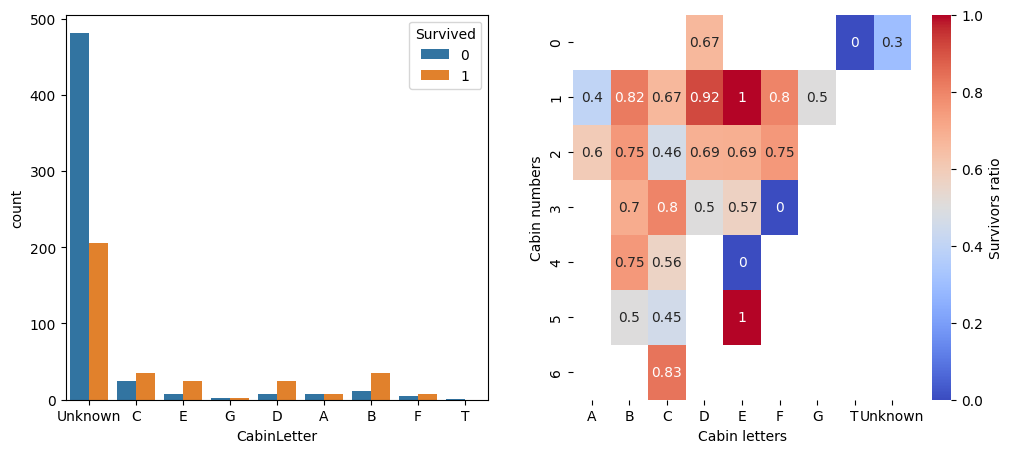

In [29]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

sns.countplot(data=df, x="CabinLetter", hue="Survived", ax=axes[0])
sns.heatmap(df.groupby(['CabinNumber', 'CabinLetter'])['Survived'].mean().unstack(),
            annot=True, cmap="coolwarm", ax=axes[1], cbar_kws={'label': 'Survivors ratio'})

axes[1].set_xlabel("Cabin letters")
axes[1].set_ylabel("Cabin numbers")

**Notes:**
- Cabins E, B and D have a considerable surviving rate.
- Most passengers whose cabin is unknown died.

In [30]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,AgeClass,Title,CabinNumber,Relatives
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,3.996633,2.528620,0.579125,0.904602
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,1.888757,0.890663,1.264543,1.613459
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,3.000000,2.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,4.000000,2.000000,0.000000,0.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,5.000000,3.000000,0.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,7.000000,5.000000,6.000000,10.000000


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  AgeClass     891 non-null    int64  
 13  Title        891 non-null    int64  
 14  CabinLetter  891 non-null    object 
 15  CabinNumber  891 non-null    int64  
 16  Relatives    891 non-null    int64  
dtypes: float64(2), int64(9), object(6)
memory usage: 118.5+ KB


In [32]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeClass,Title,CabinLetter,CabinNumber,Relatives
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,3,2,Unknown,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4,4,C,4,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3,3,Unknown,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,4,4,C,5,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,4,2,Unknown,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,3,5,Unknown,0,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,2,3,B,2,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,7,3,Unknown,0,3
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,3,2,C,6,0


# 5. Preprocessing

Labels:

- PassengerId: drop
- Survived: target
- Pclass: ok
- Name: drop
- Sex: one hot enconding
- Age: Drop
- SibSp: ok
- Parch: ok
- Ticket: drop
- Fare: ok
- Cabin: drop
- Embarked: FillNa and OneHotEnconding
- AgeClass: ok
- Title: Ok
- CabinLetter: OneHotEnconder
- CabinNumber: ok
- Relatives: ok

In [33]:
def preprocess_dataset(df_, train):
    if train:
        y = df_["Survived"]
        x = df_.drop("Survived", axis=1)
    else:
        x = df_.copy()
    
    x.drop(["Name", "PassengerId", "Age", "Ticket", "Cabin"], axis=1, inplace=True)
    
    x["Embarked"].fillna("Unknown", inplace=True)
    
    cat_features = ["Sex", "Embarked", "CabinLetter"]
    one_hot = OneHotEncoder()
    
    sex_encoder = OneHotEncoder(categories=[["male", "female"]])
    embarked_encoder = OneHotEncoder(categories=[["S", "C", "Q", "Unknown"]])
    cabinletter_encoder = OneHotEncoder(categories=[["A", "B", "C", "D", "E", "F", "G", "T","Unknown"]])
    
    transformer = ColumnTransformer([("sex_encoder", sex_encoder, ["Sex"]),
                                    ("embarked_encoder", embarked_encoder, ["Embarked"]),
                                    ("cabinletter_encoder", cabinletter_encoder, ["CabinLetter"])],
                                    remainder = "passthrough")

    
    x_transformed = pd.DataFrame(transformer.fit_transform(x))
    
    if train:
        return x_transformed, y
    
    return x_transformed

x, y = preprocess_dataset(df, train=True)

X_tr, X_ts, y_tr, y_ts = train_test_split(x, y, test_size = .25, random_state=120975)

In [34]:
x

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,7.2500,3.0,2.0,0.0,1.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,71.2833,4.0,4.0,4.0,1.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,7.9250,3.0,3.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,53.1000,4.0,4.0,5.0,1.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,8.0500,4.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,13.0000,3.0,5.0,0.0,0.0
887,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,30.0000,2.0,3.0,2.0,0.0
888,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,23.4500,7.0,3.0,0.0,3.0
889,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,30.0000,3.0,2.0,6.0,0.0


# 6. Modeling and predicting

In [35]:
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

In [36]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [37]:
test_df = test_df.apply(age_classification, axis=1)
test_df = test_df.apply(title_class, axis=1)
test_df = test_df.apply(cabin_class, axis=1)
test_df = test_df.apply(relatives_class, axis=1)
test_df["Fare"].fillna(test_df["Fare"].mean(), inplace=True)

x_test = preprocess_dataset(test_df, train=False)

x_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,7.8292,4.0,2.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,7.0000,5.0,4.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,9.6875,6.0,2.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,8.6625,3.0,2.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,12.2875,3.0,4.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,8.0500,7.0,2.0,0.0,0.0
414,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,108.9000,4.0,5.0,5.0,0.0
415,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,7.2500,4.0,2.0,0.0,0.0
416,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,8.0500,7.0,2.0,0.0,0.0


## XGBoost

In [38]:
cv = StratifiedKFold(n_splits=5, random_state = 120975, shuffle=True)

model = xgb.XGBClassifier(eval_metric='logloss', seed=120975)

score = cross_val_score(model , X_tr, y_tr, cv=cv, scoring='roc_auc')

print(f'mean: {score.mean()} std: {score.std()}')

mean: 0.8565755441591438 std: 0.011456411089793842


In [39]:
model.fit(X_tr, y_tr)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [40]:
# using GridSearch to find the best parameters

# tuning learning_rate and n_estimators
params = {
    "subsample":[0.8],
    "colsample_bytree":[0.8],
    "learning_rate":[0.0001, 0.001, 0.01, 0.1, 0.2,0.3],
    "n_estimators": range(50,500,50)
}

grid = GridSearchCV(model, params, cv=cv, scoring="roc_auc")

grid.fit(X_tr, y_tr)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=120975, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     impor...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.8],
                         'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
                         'n_estimators': range(50, 500, 50),
                         'subsample': [0.8]},
             scoring='roc_auc')

In [41]:
score = roc_auc_score(y_ts, grid.predict_proba(X_ts)[:,1])

print(f"Tuned score: {score}")

Tuned score: 0.8586021505376344


In [42]:
grid.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.01,
 'n_estimators': 50,
 'subsample': 0.8}

In [43]:
# tuning max_depth and min_child_weight
params = {
    "subsample":[0.8],
    "colsample_bytree":[0.8],
    "learning_rate":[0.01],
    "n_estimators": [50],
    "max_depth": range(2,10,2),
    "min_child_weight": range(1,6,2)
}

grid = GridSearchCV(model, params, cv=cv, scoring="roc_auc")
grid.fit(X_tr, y_tr)

score = roc_auc_score(y_ts, grid.predict_proba(X_ts)[:,1])
print(f"Tuned score: {score}")
print(grid.best_params_)

Tuned score: 0.8604218362282878
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.8}


In [44]:
# tuning model__gamma and model__reg_lambda
params = {
    "subsample":[0.8],
    "colsample_bytree":[0.8],
    "learning_rate":[0.01],
    "n_estimators": [50],
    "max_depth": [8],
    "min_child_weight": [1],
    "model__gamma": [i/10.0 for i in range(0,6)],
    "model__reg_lambda": [0, 0.5, 1, 1.5, 2, 3, 4.5]
}

grid = GridSearchCV(model, params, cv=cv, scoring="roc_auc")

grid.fit(X_tr, y_tr)

score = roc_auc_score(y_ts, grid.predict_proba(X_ts)[:,1])
print(f"Tuned score: {score}")
print(grid.best_params_)

Tuned score: 0.8604218362282878
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'model__gamma': 0.0, 'model__reg_lambda': 0, 'n_estimators': 50, 'subsample': 0.8}


In [45]:
res = grid.predict(x_test)
res

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [46]:
df_res = pd.DataFrame({"PassengersId":test_df["PassengerId"].tolist(), "Survived": res})
df_res

,PassengersId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [47]:
df_res.to_csv("result.csv", index=False)

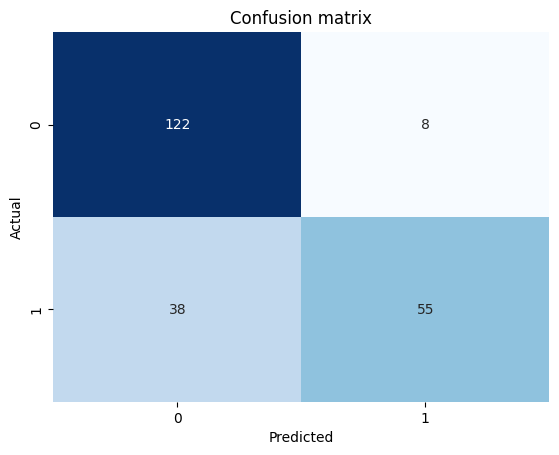

In [48]:
conf_mat = confusion_matrix(y_ts, grid.predict(X_ts))

sns.heatmap(conf_mat, cmap="Blues", annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix")
plt.show()

In [49]:
pd.DataFrame(classification_report(y_ts, grid.predict(X_ts), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.762500,0.873016,0.793722,0.817758,0.808590
recall,0.938462,0.591398,0.793722,0.764930,0.793722
f1-score,0.841379,0.705128,0.793722,0.773254,0.784557
support,130.000000,93.000000,0.793722,223.000000,223.000000


In [50]:
acc_score = cross_val_score(grid, X_ts,y_ts, cv=cv, scoring="accuracy")
auc_score = cross_val_score(grid, X_ts,y_ts, cv=cv, scoring="roc_auc")

In [51]:
print(f"ROC AUC score:\t{auc_score.mean():.2f} +- {auc_score.std():.2f};\nAccuracy:\t{acc_score.mean():.2f} +- {acc_score.std():.2f}")

ROC AUC score:	0.81 +- 0.06;
Accuracy:	0.78 +- 0.03
